<div style="text-align: right"><strong>Capstone #3:</strong> <span style="color:darkred">Supervised Learning</span> </div>

<a id="top"></a>

 ---------

# <span style="color:darkblue">L1 Prediction from ELL Writing Samples </span>

__Author:__ Ryan Harper 

----

![Image of Languages](http://humanities.drury.edu/wp-content/uploads/2017/04/post-picture-2.png)

----

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Exploring the Data</a><br>
<a href='#sec3'>3. Models:</a><br>
><a href='#seca'>A. LR - Ordinary Least Squares</a><br>
<a href='#secb'>B. LR - Logistic Regression</a> <a href='#secb1'> (Lasso)</a> <a href='#secb2'> (Ridge)</a><br>
<a href='#secc'>C. NN - K Nearest Neighbors</a><br>
<a href='#secd'>D. NN - Naive Bayes</a><br>
<a href='#sece'>E. NN - Decision Tree</a><br>
<a href='#secf'>F. Ensemble - Random Forest</a><br>

<a href='#sec4'>4. Model Comparison</a><br>

<a id="ov"></a>

# <span style="color:darkblue">Overview</span>  <a href='#top'>(top)</a>

__Data Source:__
> http://lang-8.com/ [scraped with Beautiful Soup]

__Summary:__
> For the past ten years, I have been teaching English to a diverse range of students of all ages, language background, and country origin. During my professional development, I started to observe that different students with different L1s (1st Language) tended to display different patterns of communication that appeared to have some connection to either education in their country of origin or a connection to the linguistic structure of their first language.Different ELL (English Language Learners) needed to focus on different aspects of the English language depending on their background. The purpose of this project is to use a large number of blog posts from a language practicing website and explore whether or not the L1 has any significant impact on the blog writing style of the English learner.<br><br>Part 1: Explore the data to find any noteworthy trends in linguistic structure: <ol><li> vocabulary (word freq, collocations, and cognates) <li>syntax (sentence structure)<li>grammar (i.e. grammar complexity of sentences) <li>errors (types of errors) <li> parts of speech (freq of different types of parts of speech)</ol><br>Part 2: Use linguistic trends to determine whether or not a learner's first language can be predicted.

__Variables:__
>__id:__ _User ID_<br>
__time:__ _Time the blog post was scraped (in order of user posted time)_ <br>
__title:__ _Title of the blog post_<br>
__content:__ _The blog post_<br>
__language:__ _User's self-reported first language_

<a id="exp"></a>

# <span style="color:darkblue">Experiment</span> <a href='#top'>(top)</a>

__Hypothesis:__ 
> L1 (first language) experience and academic environment influences ELLs' (English Language Learners') writing style. The L1 of ELLs can be predicted by looking at English blog posts and identifying patterns unique to their L1.

__Observations:__
><li> --<li>--<li>--

__Method:__
> Using multiple different models. The aim of this project is to explore how different models can handle the data (target and features) and to see what information can be gained from using multiple different models. Ultimately, the goal is to determine which models are appropriate for a binary (discrete) target with features that are both qualitative (discrete) and quantitative (ranked/continuous).

<a id="sec1"></a>

# <span style="color:darkblue">1. Cleaning the Data</span>  <a href='#top'>(top)</a>

In [1]:
# iPython/Jupyter Notebook
import time
from pprint import pprint
import warnings

# Data processing
import pandas as pd
import plotly as plo
import seaborn as sns
from scipy import stats
from collections import Counter

# NLP
from nltk.corpus import stopwords as sw
from nltk.util import ngrams
import nltk
import re
from nltk.tokenize import RegexpTokenizer

# Preparing Models
from sklearn.model_selection import train_test_split

# Models
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import BernoulliNB

# Ensemble
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#Visualization
from IPython.display import Image
import pydotplus
import graphviz

In [2]:
# Jupyter Settings and Imports
%pylab
%matplotlib inline 
warnings.filterwarnings(action='once')

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Import data
blog = pd.read_csv('../data/language/blogdata-reduced.csv')
del blog['Unnamed: 0']

In [4]:
blog.info(verbose=False, memory_usage=False,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12640 entries, 0 to 12639
Columns: 5 entries, id to language
dtypes: int64(1), object(4)

In [5]:
# Confirmation that there are no more null values
blog.isnull().values.any()

False

In [6]:
blog.head()

,id,time,title,content,language
0,1,2018-03-15 23:52:01.424272+00:00,I'm going to Silicon Valley!,I will visit Silicon Valley in California bet...,Japanese
1,1,2018-03-15 23:52:06.279421+00:00,Sightseeing in Kyoto,My parents want to take their Chinese guests ...,Japanese
2,1,2018-03-15 23:52:09.582504+00:00,Shaku-gan no SHANA,Do you know a Japanese animation (and novel) ...,Japanese
3,2,2018-03-16 00:00:59.456895+00:00,Unlucky,I went to watch a featherweight throne jump-o...,Japanese
4,2,2018-03-16 00:01:03.120751+00:00,Stone Art???,There is a traditional custum that a blood re...,Japanese


<a id="sec2"></a>

# <span style="color:darkblue">2. Exploring the Data</span>  <a href='#top'>(top)</a>

In [7]:
blog['char_count'] = blog.content.apply(len)

In [8]:
def reject_outliers(data, m=3):
    data = data[abs(data - np.mean(data)) < m*np.std(data)]
    return data[~numpy.isnan(data)]

lanlenseries = [reject_outliers(blog.char_count[blog.language == l]) for l in list(blog.language.unique())]

/Users/ryan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/Users/ryan/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:195: RuntimeWarning:

Mean of empty slice.

/Users/ryan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars

/Users/ryan/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning:

invalid value encountered in true_divide



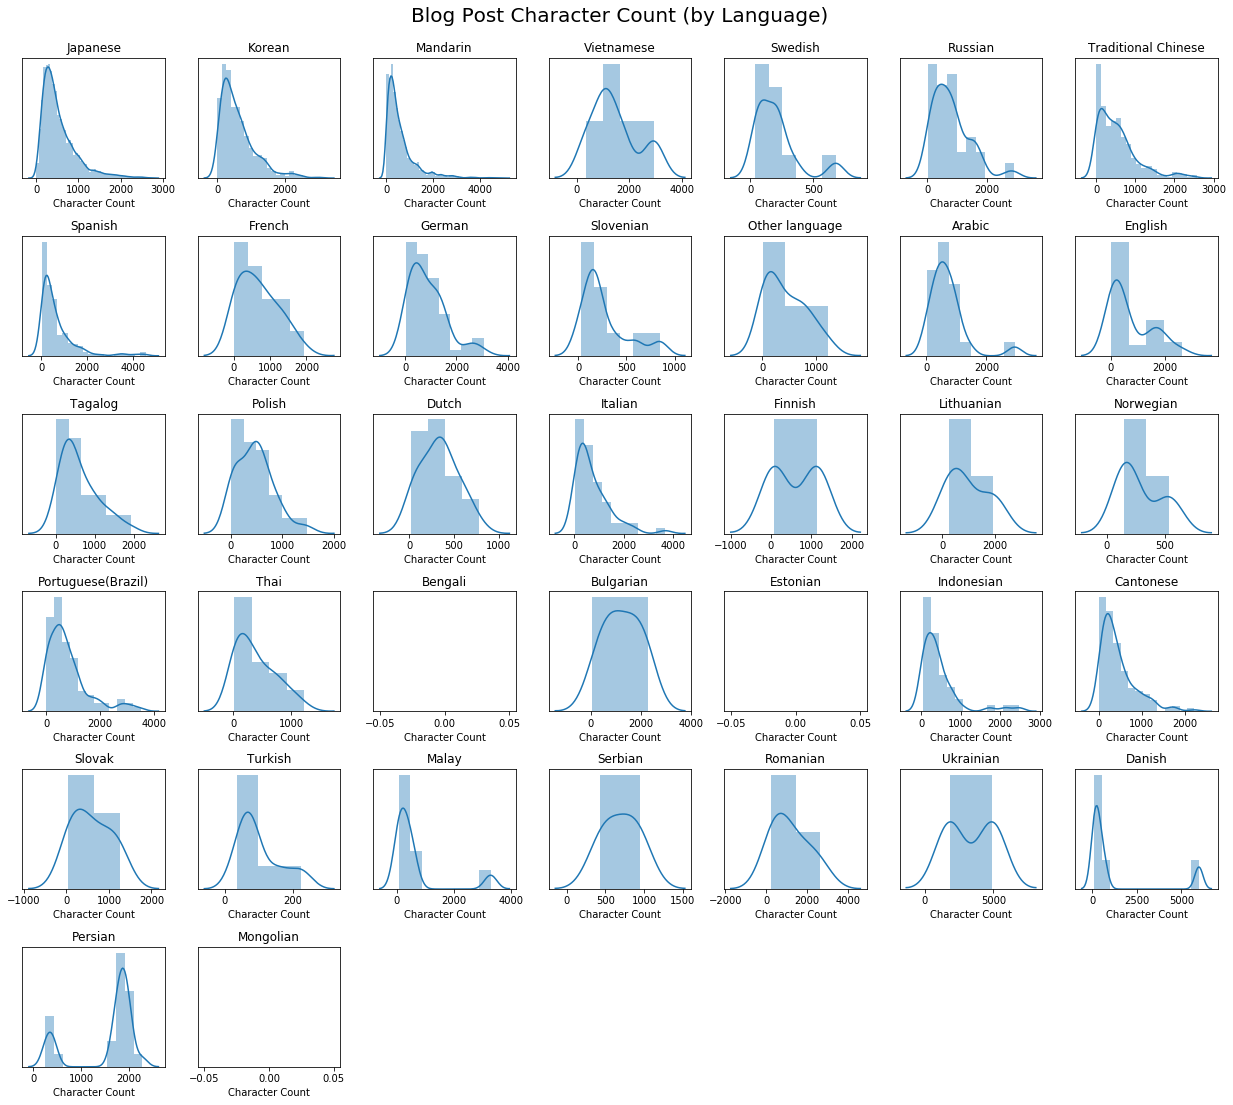

In [9]:
i = 1
plt.figure(figsize=(17,17))

languages = [l for l in list(blog.language.unique())]

for n, column in enumerate(lanlenseries):
    plt.subplot(7, 7, i)
    i = i + 1
    sns.distplot(column)
    plt.title(languages[n])
    plt.yticks([])
    plt.xlabel('Character Count')

plt.tight_layout()
plt.suptitle('Blog Post Character Count (by Language)',fontsize=20,y=1.02)
plt.show()

<a id="nlp"></a>

#### <span style="color:darkred">NLP: Tokenization, Collocations, Parts of Speech, and Syntax</span>  <a href='#top'>(top)</a>

In [10]:
def tokendict(d):
    for sw in stop_words:
        if sw in d:
            del d[sw]
    return d

In [11]:
stop_words = set(sw.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

/Users/ryan/anaconda3/lib/python3.6/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/ryan/nltk_data/corpora/stopwords/english'>



In [12]:
lantokens = list(zip([tokendict(Counter(np.concatenate(np.array(blog.content[blog.language == l].str.lower().apply(tokenizer.tokenize))))) for l in list(blog.language.unique())],[l for l in list(blog.language.unique())]))

In [13]:
blog['tokens'] = blog.content.str.lower().apply(tokenizer.tokenize)

In [14]:
punct = re.compile(r'\w')

def onlygetPOS(val):
    words = nltk.word_tokenize(val)
    tagged = nltk.pos_tag(words)

    pos = []

    for i,v in tagged:
        if regexp.search(v):
            pos.append(v)
        else:
            pos.append('PUNCT')

    return pos

def getPOS(val):
    words = nltk.word_tokenize(val)
    tagged = nltk.pos_tag(words)

    pos = []

#     for i,v in tagged:
#         if v == ',':
#             None
#         else:
#             pos.append((i,v))

    return tagged

def getSYNTAX(val):
    # My personal syntax tree (needs improvement)
    chunkGram = r"""
    Question: {^<WP|WRB>|^<MD>}
    Passive: {<RB>?<MD>?<RB>?<VBD|VB|VBP><RB>?<VBN><RB>?<VBN>?}
    Active: {<RB>?<MD>?<RB>?<VB\w?>+<RB>?}
    CP: {<JJ\w?>+}
    NP:{(<DT|PRP.>|<CP>)<N\w+|PRP>}
    NPC: {<NP><CC><NP>}
    PP:{<IN><NP>}
    INF:{<TO><VB><PP>?}
    PRT: {<VBG>}
    NPP: {<NP|PP|INF|PRT><NP|PP|INF|PRT>}
    Subject: {<NP|NPP|NPC|N\w+|PRP>}<Active|Passive>
    Object: <Active|Passive|Imperative>{<NP|NPP|NPC|N\w+|PRP>|(<IN><NPP|NP|N\w+|PRP>)}
    Imperative: {^<Active>}
    Adverbial: {<RB>}

    """

    chunkParser = nltk.RegexpParser(chunkGram)
    chunked = chunkParser.parse(getPOS(val))
    return chunked

In [15]:
blog['pos'] = blog.content.str.lower().apply(onlygetPOS)

NameError: name 'regexp' is not defined

In [ ]:
poscount = list(zip([tokendict(Counter(np.concatenate(np.array(blog.pos)))) for l in list(blog.language.unique())],[l for l in list(blog.language.unique())]))

In [ ]:
# # create set of stop words from nltk corpus
# def bigram(value):
#     tokens = nltk.word_tokenize(value)
#     bigrm = list(nltk.bigrams(tokens))
#     bigramlist = []
    
#     for bigram in bigrm:
#         bigramlist.append(' '.join(bigram))
        
#     return bigramlist

In [ ]:
def wcount(val):
    if w in val.lower():
        return 0
    else:
        return 1

__Correlations__

__A. Scatterplot using univariate and bivariate methods__

_Before cleaning data_

In [ ]:
# Make the scatterplot matrix
featurelist = ['age','trestbps','chol','thalach','oldpeak','exang','num']
locations = ['cleveland', 'hungarian', 'switzerland', 'va']
palette = ['r','b','g','y']

i = 1
fig=plt.figure(figsize=(15,10))

for column in featurelist:
    plt.subplot(4, 2, i)
    i = i + 1
    for idx, location in enumerate(locations):
        sns.kdeplot(heartdf[column].loc[heartdf['location'] == location], color = palette[idx])
    plt.title(column)
    plt.legend(locations)

plt.show()

_After cleaning data_

In [ ]:
# Make the scatterplot matrix
featurelist = ['age','trestbps','chol','thalach','oldpeak']


g = sns.PairGrid(data=heart, diag_sharey=False, hue="location", vars=featurelist, palette=['r','b','g','y'])
g.map_offdiag(plt.scatter, alpha=.5)
g.map_diag(sns.kdeplot, lw=3)

g.add_legend()

plt.show()

<a id="sec3"></a>

###  <span style="color:darkblue">C. Statistical Significance <a href='#top'>(top)</a>

__A. Mood’s Median test (2+ Non-Normally Distributed Independent Samples)__

_ __Null Hypothesis:__ Assumes no statistically significant difference between samples._

In [ ]:
stat, p, med, tbl = median_test(heart['chol'].loc[heart['location'] == 'hungarian'],heart['chol'].loc[heart['location'] == 'va'],heart['chol'].loc[heart['location'] == 'cleveland'])
print(stat,med)
print(p)

p-value is not less than 5% and doesn't disprove the null hypothesis. There may not be statistical significance between Hungarian, VA, and Cleveland cholesterol samples.

In [ ]:
stat, p, med, tbl = median_test(heart['oldpeak'].loc[heart['location'] == 'hungarian'],heart['oldpeak'].loc[heart['location'] == 'va'],heart['oldpeak'].loc[heart['location'] == 'cleveland'])
print(stat,med)
print(p)

p-value is less than 5% and disproves the null hypothesis. The differences between Hungarian, VA, and Cleveland oldpeak samples are statistically significant.

__B. One-Way AnovaTest (2+ Normally Distributed Independent Samples)__

_ __Null Hypothesis:__ Assumes no statistically significant difference between samples._

In [ ]:
f, p = f_oneway(heart['chol'].loc[heart['location'] == 'hungarian'],heart['chol'].loc[heart['location'] == 'va'],heart['chol'].loc[heart['location'] == 'cleveland'])

print("F-Value: {}, p:{}".format(f,p))

p-value is not less than 5% and doesn't disprove the null hypothesis. There may not be statistical significance between Hungarian, VA, and Cleveland samples.

In [ ]:
f, p = f_oneway(heart['oldpeak'].loc[heart['location'] == 'hungarian'],heart['oldpeak'].loc[heart['location'] == 'va'],heart['oldpeak'].loc[heart['location'] == 'cleveland'])

print("F-Value: {}, p:{}".format(f,p))

p-value is less than 5% and disproves the null hypothesis. The differences between Hungarian, VA, and Cleveland oldpeak samples are statistically significant.

<a id="sec3"></a>

# <span style="color:darkblue">Models:</span>  <a href='#top'>(top)</a>

In [ ]:
# feature data for models
features = blog.copy()
features.head()
features = features.sample(frac=1.0)

In [ ]:
y = features['gender'].values.reshape(-1, 1).ravel()
X = features[['year','len', 'vowelp', 'cc', 'yc', 'fvowel','lcons','lconslet','fvowellet']]

print(np.shape(y))
print(np.shape(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)  

<a id="seca"></a>

### <span style="color:darkblue">A. LR - Ordinary Least Squares</span>  <a href='#top'>(top)</a>

> Target is binary so this model may not be appropriate <br>Many features are binary so model may not be appropriate <br>Predicted values are not binary and need to be rounded up/down

In [ ]:
%%capture timeA --no-stderr
%%time

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(X_train, y_train)

In [ ]:
regr.coef_

In [ ]:
# Display the attributes
print('Coefficients: \n')
pprint(list(zip(X.columns,regr.coef_)))
print('\nIntercept: \n', regr.intercept_)
coef = list(zip(X.columns,regr.coef_))

In [ ]:
# Visualization of gender approximation
x = list(range(len(y_test[0:30])))
y =[0.5]*len(y_test[0:30])

predY = regr.predict(X_test)
plt.scatter(range(len(y_test[0:30])),predY[0:30],c='red',s=1)
plt.scatter(range(len(y_test[0:30])),y_test[0:30],c='blue',s=1)
plt.plot(x,y,c='black')
plt.legend(['Threshold','Actual','Predicted'],loc='upper right')
plt.show()

In [ ]:
# score is low because of approximate values with lin regression - values need to be rounded
regr.score(X_test,y_test)

In [ ]:
# create vectorizer function for numpy
vfunc =  np.vectorize(lambda val: int(round(abs(val))))

# create final copy
final = X_test.copy()
final['gender'] = y_test
final['guessval'] = vfunc(regr.predict(X_test).ravel())
final.index.name = 'index'
finaln = names.copy()
finaln.index.name = 'index'
final = final.join(finaln['name'], how='left', on='index')
print('{0:f}% of names were correctly identified by gender'.format(
    100*len(final.loc[final['gender'] == final['guessval']]) / len(final)))
scoreA = len(final.loc[final['gender'] == final['guessval']]) / len(final)
del final
del finaln

<a id="secb"></a>

### <span style="color:darkblue">B. LR - Logistic Regression</span>  <a href='#top'>(top)</a>

> Target is binary so logistic regression will operate on probabilities

In [ ]:
%%capture timeB --no-stderr
%%time

# Instantiate our model.
lregr = linear_model.LogisticRegression()

# Fit our model to our data.
lregr.fit(X_train, y_train)

In [ ]:
lregr.coef_

In [ ]:
# Display the attributes
print('Coefficients: \n')
pprint(list(zip(X.columns,lregr.coef_[0])))
print('\nIntercept: \n', lregr.intercept_)
coef = list(zip(X.columns,lregr.coef_[0]))

In [ ]:
print(lregr.score(X_test,y_test))
scoreB = lregr.score(X_test,y_test)

In [ ]:
lregr.score(X_test,y_test)

<a id="secb1"></a>

#### <span style="color:darkred">B1. Lasso</span>  <a href='#top'>(top)</a>

In [ ]:
lamvalues = [.1,.25,.5,.75,1,3,5,10]

for lam in lamvalues:
    # Instantiate our model.
    lasso = linear_model.Lasso(alpha=lam,fit_intercept=False)
    
    # Fit our model to our data.
    lasso.fit(X_train, y_train)
    
    print('\u03bb={} \tLasso Score: {}'.format(lam, lasso.score(X_test,y_test)))

<a id="secb2"></a>

#### <span style="color:darkred">B2. Ridge</span>  <a href='#top'>(top)</a>

In [ ]:
lamvalues = [.1,.5,.75,1,3,5,10]

for lam in lamvalues:
    # Instantiate our model.
    ridg = linear_model.Ridge(alpha=lam,fit_intercept=False)
    
    # Fit our model to our data.
    ridg.fit(X_train, y_train)
    
    print('\u03bb={} \tRidge Score: {}'.format(lam, ridg.score(X_test,y_test)))

_Lasso and Ridge are not good predictors so should I just be using them for parameter manipulation?_

<a id="secc"></a>

### <span style="color:darkblue">C. K Nearest Neighbors</span>  <a href='#top'>(top)</a>

> Can handle discrete values for target <br>Quantitative values are limited (not continuous) and might be problematic for nearest neighbors

In [ ]:
%%capture timeC --no-stderr
%%time
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X_train, y_train.ravel())

In [ ]:
print(neighbors.score(X_test,y_test))
scoreC = neighbors.score(X_test,y_test)

<a id="secc"></a>

### <span style="color:darkblue">D. Naive Bayes - Bernoulli</span>  <a href='#top'>(top)</a>

> Should be best for boolean classification but has lowest prediction score

In [ ]:
%%capture timeD --no-stderr
%%time
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

In [ ]:
print(bnb.score(X_test,y_test))
scoreD = bnb.score(X_test,y_test)

<a id="sece"></a>

### <span style="color:darkblue">E. Decision Tree</span>  <a href='#top'>(top)</a>

> Visualizes most important features by hierarchy <br>Longer processing time

In [ ]:
%%capture timeE --no-stderr
%%time

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3)

decision_tree.fit(X_train, y_train)

In [ ]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Female', 'Male'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
scoreE=decision_tree.score(X_test,y_test)
decision_tree.score(X_test,y_test)

_Good visualization of important features and presentation of entropy weighting_

<a id="secf"></a>

### <span style="color:darkblue">F. Random Forest</span>  <a href='#top'>(top)</a>

> Runs decision tree multiple times for best output <br>Longest processing time

In [ ]:
%%capture timeF --no-stderr
%%time

rfc = ensemble.RandomForestClassifier(n_estimators=20)
rfc.fit(X_train,y_train.ravel())

In [ ]:
cvs = cross_val_score(rfc, X_test, y_test.ravel(), cv=5)
print(cvs)
scoreF = cvs.sum()/len(cvs)

In [ ]:
rfc.score(X_train,y_train)

In [ ]:
rfc.feature_importances_
importance = list(zip(X.columns,rfc.feature_importances_))

<a id="sec4"></a>

# <span style="color:darkblue">4. Model Comparison</span>  <a href='#top'>(top)</a>

In [ ]:
print('OLS Coefficients:')
pprint(coef)
print('\nDecision Tree Importance:')
pprint(importance)

In [ ]:
models = ['Ordinary Least Squares','Logistic Regression','K Nearest Neigbbors','Naive Bayes Bernoulli','Decision Tree','Random Forest']
times = [timeA,timeB,timeC,timeD,timeE,timeF]
timesfinal = []
for time in times:
    timesfinal.append((((time.stdout.splitlines())[0].split(','))[0].split('user '))[1])
score = [str(scoreA)[0:7]+('*'),scoreB,scoreC,scoreD,scoreE,scoreF]

dfModels = pd.DataFrame(index=models)
dfModels['cpu time'] = timesfinal
dfModels['score'] = score
dfModels